# Setup

## Imports & Settings

In [1]:
%load_ext autoreload
%autoreload 2

import os
import re
import scanpy as sc
from anndata import AnnData
import pandas as pd
import numpy as np
import corescpy as cr

# Computing Resources
gpu = False
sc.settings.n_jobs = 4
sc.settings.max_memory = 150

# Display
pd.options.display.max_columns = 100
pd.options.display.max_rows = 500
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(20, 20))

# Column Names (from Metadata & To Be Created)
col_sample_id_o, col_sample_id = "Sample ID", "Sample"  # in metadata, new
col_subject = "Patient"  # in metadata file
col_inflamed, col_stricture = "Inflamed", "Stricture"  # in metadata file
col_condition = "Condition"  # constructed from col_inflamed & col_stricture
col_fff = "file_path"  # column in metadata in which to store data file path
col_cell_type = "Annotation"  # for eventual cluster annotation column
col_tangram = "tangram_prediction"  # for future Tangram imputation annotation

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

## Options & Data

In [18]:
# Directories & Metadata
run = "CHO-006"
# run = ["CHO-001", "CHO-002", "CHO-005", "CHO-006"]
samples = "all"
# samples = ["50007B2"]
# samples = "all"
# samples = ["50452A"]
# samples = ["50452B"]
# samples = ["50452A", "50452B", "50452C"]
# samples = ["50564A4", "50618B5"]

# Main Directories
# Replace manually or mirror my file/directory tree in your home (`ddu`)
ddu = os.path.expanduser("~")
ddm = "/mnt/cho_lab" if os.path.exists("/mnt/cho_lab") else "/mnt"  # Spark?
ddl = f"{ddm}/disk2/{os.getlogin()}/data/shared-xenium-library" if (
    "cho" in ddm) else os.path.join(ddu, "shared-xenium-library")
ddx = f"{ddm}/bbdata0/xenium"  # mounted drive Xenium folder
out_dir = os.path.join(ddl, "outputs", "TUQ97N", "nebraska")  # None = no save
d_path = os.path.join(ddm, "disk2" if "cho" in ddm else "",
                      os.getlogin(), "data")  # other, e.g., Tangram data
file_ann = os.path.join(ddu, "corescpy/examples/annotation_guide.xlsx")  # AG
file_mdf = os.path.join(ddl, "Xenium_Samples_03152024.xlsx")  # metadata

# Annotation & Tangram Imputation
col_assignment = "Bin"  # which column from annotation file to use
# col_cell_type_sc, file_sc = "ClusterAnnotation", str(
#     f"{d_path}/2023-05-12_CombinedCD-v2_ileal_new.h5ad")
col_cell_type_sc, file_sc = "cell_type", f"{d_path}/elmentaite_ileal.h5ad"

# Processing & Clustering Options
method_norm = "log"
# custom_thresholds = {col_qscore: [, None]}
genes_subset, use_highly_variable = True, False  # genes to use in clustering
kws_pp = dict(cell_filter_pmt=None, cell_filter_ncounts=[50, None],
              cell_filter_ngene=[10, None], gene_filter_ncell=[3, None],
              gene_filter_ncounts=[3, None], custom_thresholds=None,
              kws_scale=dict(max_value=10, zero_center=True),
              method_norm=method_norm)  # preprocessing keyword arguments
kws_clustering = {}
for i in zip([0.5, 0.75, 1.5], [0.5, 0.3, 0], [30, 30, 30]):
    kws = {**kws_cluster, "resolution": i[0], "kws_umap": {
        **kws_cluster["kws_umap"], "min_dist": i[1]}, "n_comps": i[2]}
    suff = str(f"res{re.sub('[.]', 'pt', str(kws['resolution']))}_dist"
            f"{re.sub('[.]', 'pt', str(kws['kws_umap']['min_dist']))}"
            f"_npc{kws['n_comps']}")  # file path suffix
    kws_clustering.update({suff: kws})

# After this point, no more options to specify
# Just code to infer the data file path from your specifications
# and construct argument dictionaries and manipulate metadata and such.

# Read Metadata & Other Information
annot_df = pd.read_excel(file_ann)
metadata = pd.read_excel(file_mdf, dtype={"Slide ID": str}).rename(
    {"Name": col_subject, "Inflammation Status": col_inflamed}, axis=1)
if samples not in ["all", None]:  # subset by sample ID?
    metadata = metadata.set_index(col_sample_id_o).loc[samples].reset_index()

# Construct Clustering Argument Keyword Dictionaries
if genes_subset is True:
    genes_subset = list(annot_df.iloc[:, 0])
kws_umap = dict(method="rapids" if gpu else "umap")
kws_cluster = dict(use_gpu=gpu, kws_umap=kws_umap, genes_subset=genes_subset,
                   use_highly_variable=use_highly_variable)

# Revise Metadata & Construct Variables from Options
metadata.loc[:, col_condition] = metadata.apply(lambda x: "Stricture" if x[
    col_stricture].lower() in ["stricture", "yes"] else x[
        col_inflamed].capitalize(), axis=1)  # inflamation/stricture condition
metadata.loc[:, col_sample_id] = metadata[[col_condition, col_sample_id_o]
                                          ].apply("-".join, axis=1)
metadata = metadata.set_index(col_sample_id)
fff = np.array(cr.pp.construct_file(run=run, directory=ddx))
samps = np.array([i.split("__")[2].split("-")[0] for i in fff])
for x in metadata[col_sample_id_o]:
    metadata.loc[metadata[col_sample_id_o] == x, col_fff] = fff[np.where(
        samps == x)[0][0]] if len(np.where(samps == x)[0]) > 0 else np.nan
metadata = metadata.dropna(subset=[col_fff])

# Annotation File
assign = pd.read_excel(file_ann, index_col=0).dropna(
    subset=col_assignment).rename_axis("Gene")[[col_assignment]]
marker_genes_dict = dict(assign.reset_index().groupby(col_assignment).apply(
    lambda x: list(pd.unique(x.Gene))))  # to marker dictionary

# Print Metadata & Make Output Directory (If Not Present)
print(metadata)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Load Data
selves = [None] * metadata.shape[0]  # to hold different samples
for i, x in enumerate(metadata.index.values):
    selves[i] = cr.Spatial(
        metadata.loc[x][col_fff], library_id=x, col_sample_id=col_sample_id,
        col_subject=col_subject, col_cell_type=col_cell_type)
    for j in metadata:  # iterate metadata columns
        selves[i].rna.obs.loc[:, j] = str(metadata.loc[x][j])  # add to object
    selves[i].rna.obs.loc[:, "out_file"] = os.path.join(
        out_dir, s._library_id)  # output path (to save object)



<<< INITIALIZING SPATIAL CLASS OBJECT >>>



<<< INITIALIZING OMICS CLASS OBJECT >>>




col_gene_symbols="gene_symbols"
col_cell_type="Annotation"
col_sample_id="Sample"
col_batch="Sample"
col_subject="Patient"
col_condition=None
col_num_umis=None



key_control=None
key_treatment=None
INFO     reading                                                                                                   
         /mnt/cho_lab/bbdata0/xenium/outputs/TUQ97N/CHO-005/output-XETG00189__0010933__50007B2-TUQ97N-EA__20240306_
         _195010/cell_feature_matrix.h5                                                                            
dsfasfda AnnData object with n_obs × n_vars = 570016 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial',

# Pre-Process, Cluster, Annotate

{'cell_filter_pmt': None, 'cell_filter_ncounts': [50, None], 'cell_filter_ngene': [10, None], 'gene_filter_ncell': [3, None], 'gene_filter_ncounts': [3, None], 'custom_thresholds': None, 'kws_scale': {'max_value': 10, 'zero_center': True}, 'method_norm': 'log'}
AnnData object with n_obs × n_vars = 570016 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Location', 'Stricture', 'Inflamed', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease_Status', 'Date Collected', 'Date Sectioned', 'Date Hybridization', 'Storage 4c', 'Created By', 'Created', 'Storage Status', 'Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Condition', 'file_path', 'out_file'
    var: 'gene_ids', 'feature_types', 'genome'
    uns:

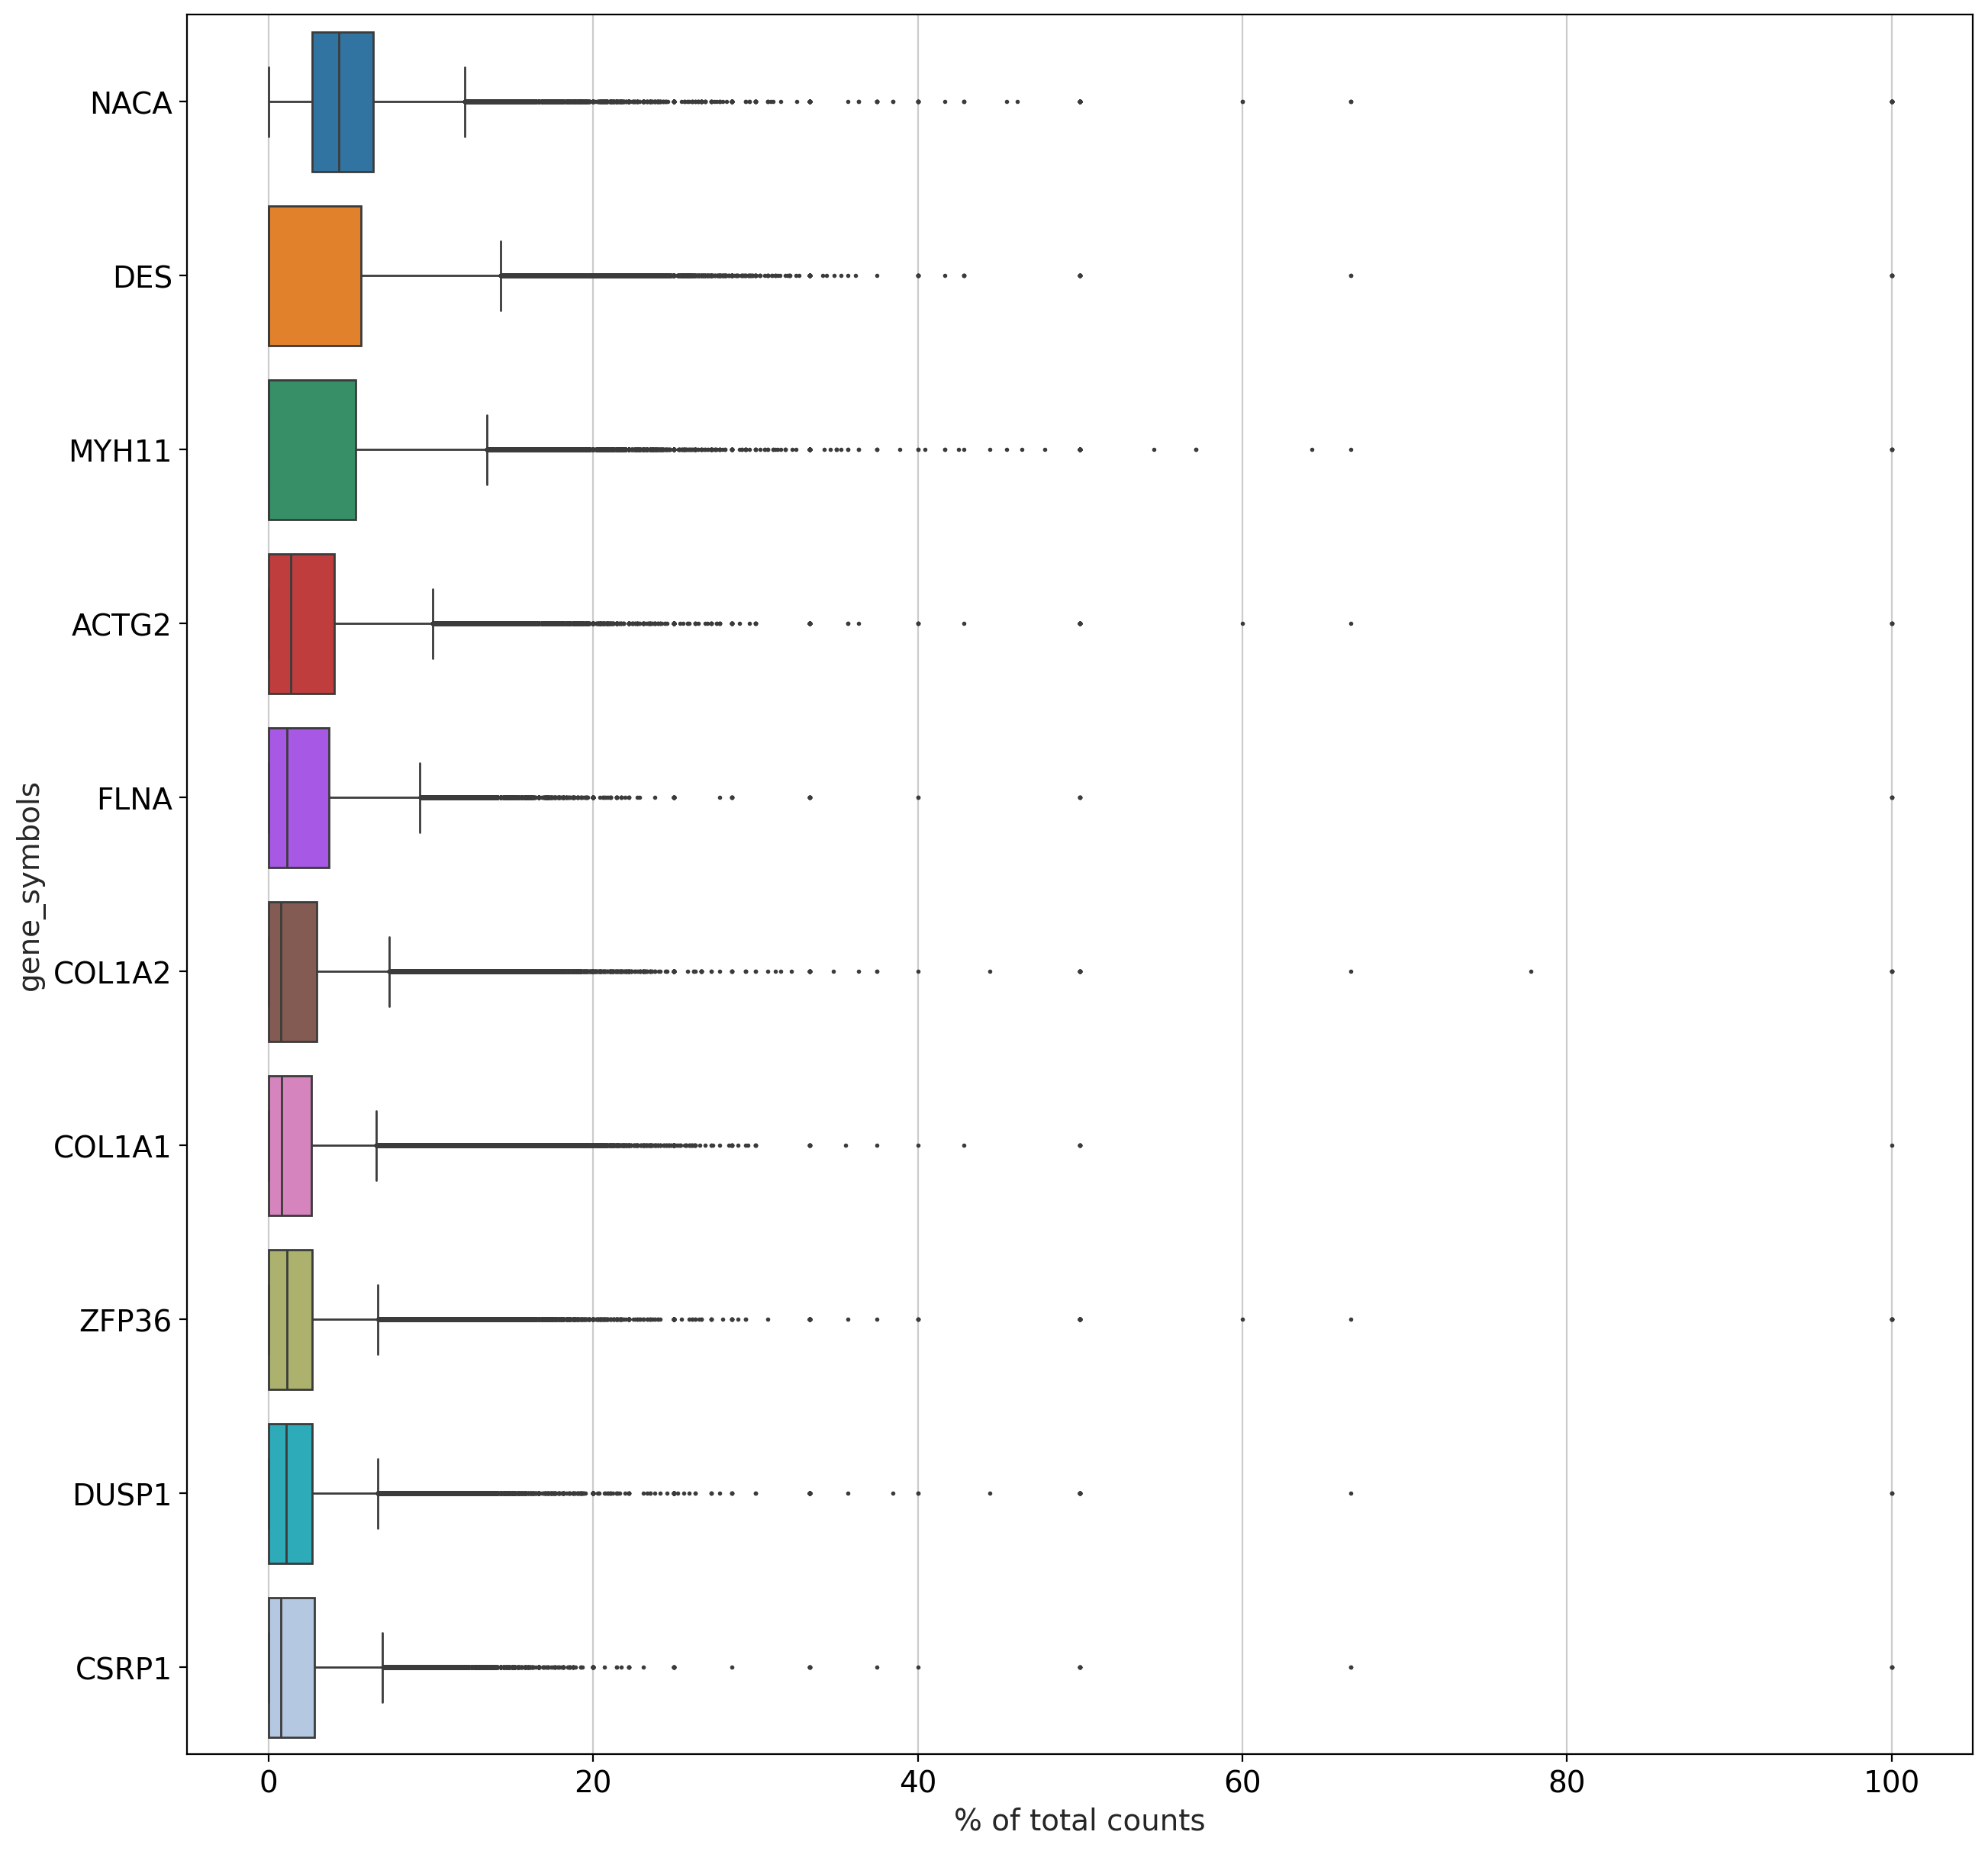

dsfasfda AnnData object with n_obs × n_vars = 570016 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Location', 'Stricture', 'Inflamed', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease_Status', 'Date Collected', 'Date Sectioned', 'Date Hybridization', 'Storage 4c', 'Created By', 'Created', 'Storage Status', 'Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Condition', 'file_path', 'out_file', 'n_counts', 'log_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial', 'original_ix'
    obsm: 'spatial'
    layers: 'counts'


Cell Counts: Initial


Observations: 570016



Gene Counts: Initial

Empty DataFrame
Columns: [gene_symbols, gene_ids, feature

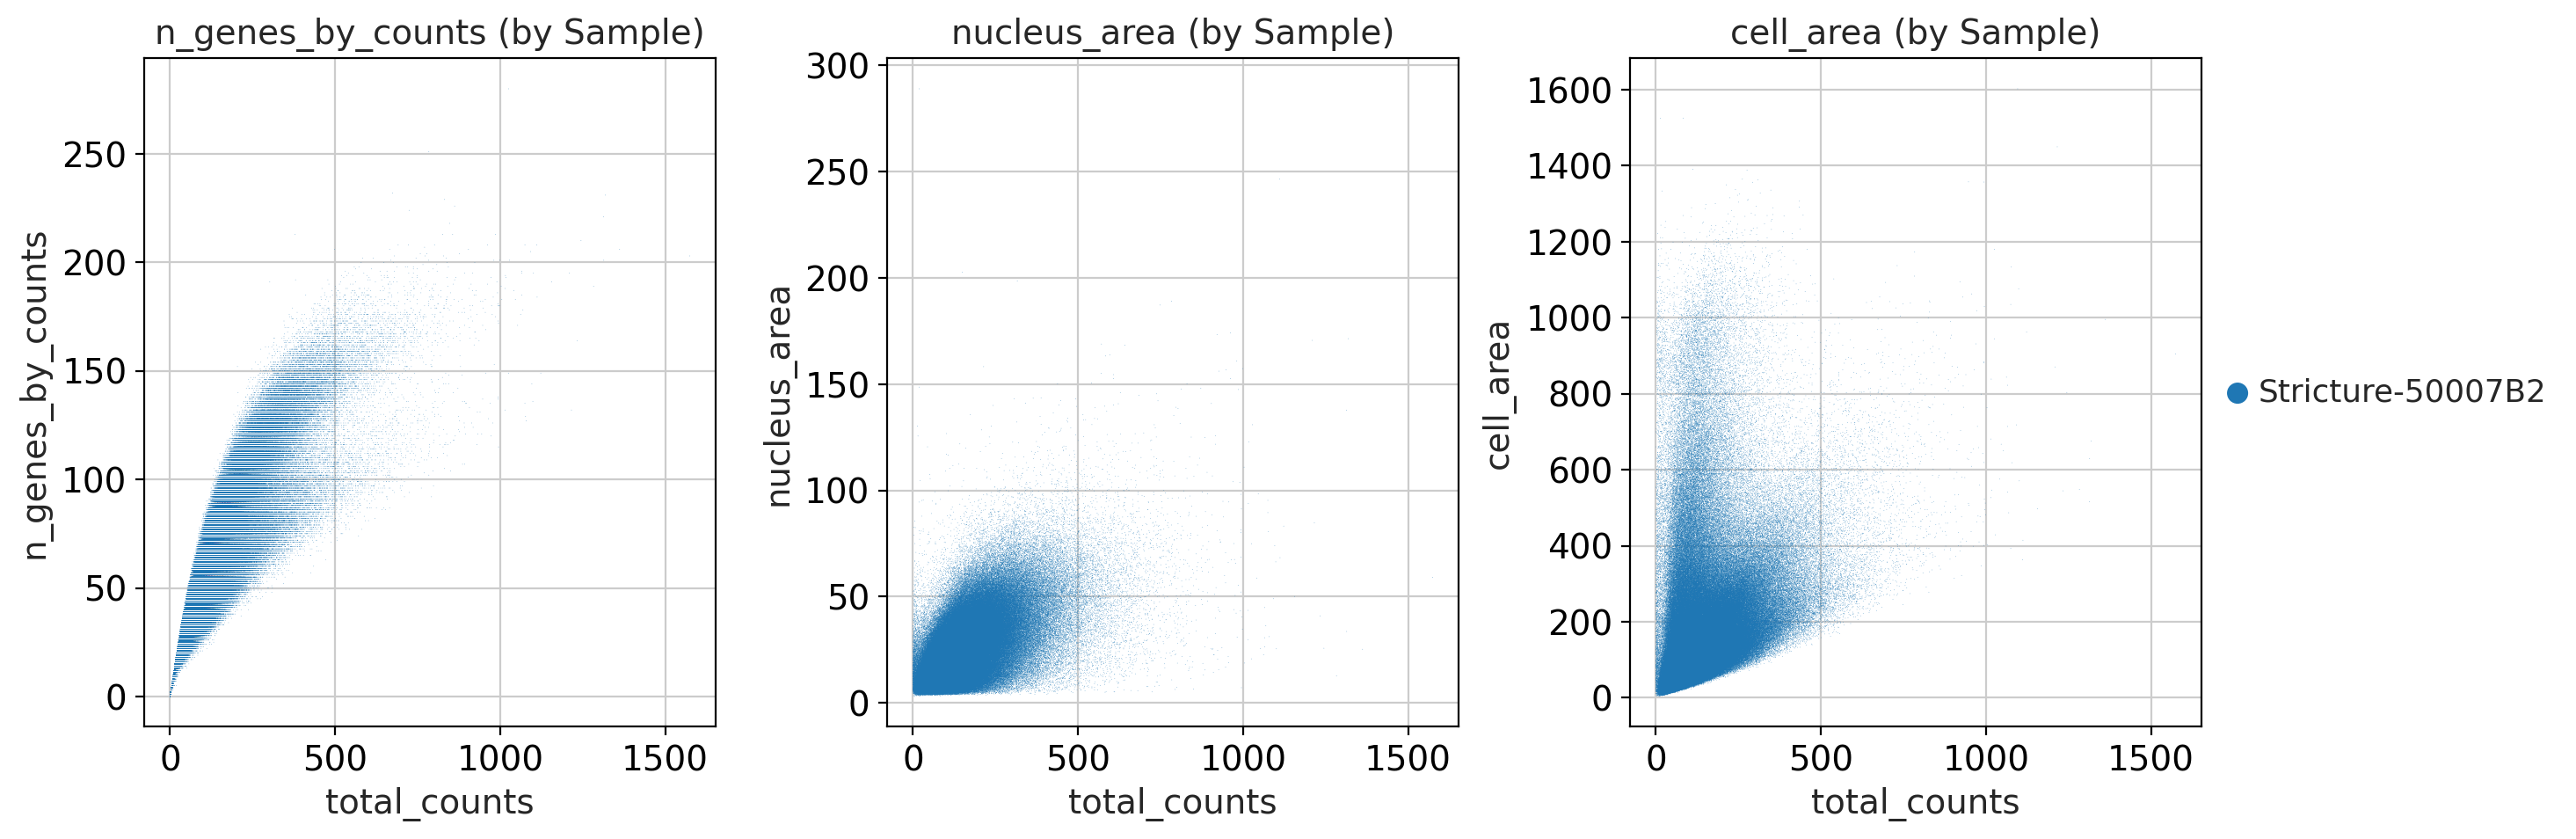


<<< FILTERING CELLS (TOO FEW GENES) & GENES (TOO FEW CELLS) >>>
dsfasfda AnnData object with n_obs × n_vars = 567366 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Location', 'Stricture', 'Inflamed', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease_Status', 'Date Collected', 'Date Sectioned', 'Date Hybridization', 'Storage 4c', 'Created By', 'Created', 'Storage Status', 'Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Condition', 'file_path', 'out_file', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropou

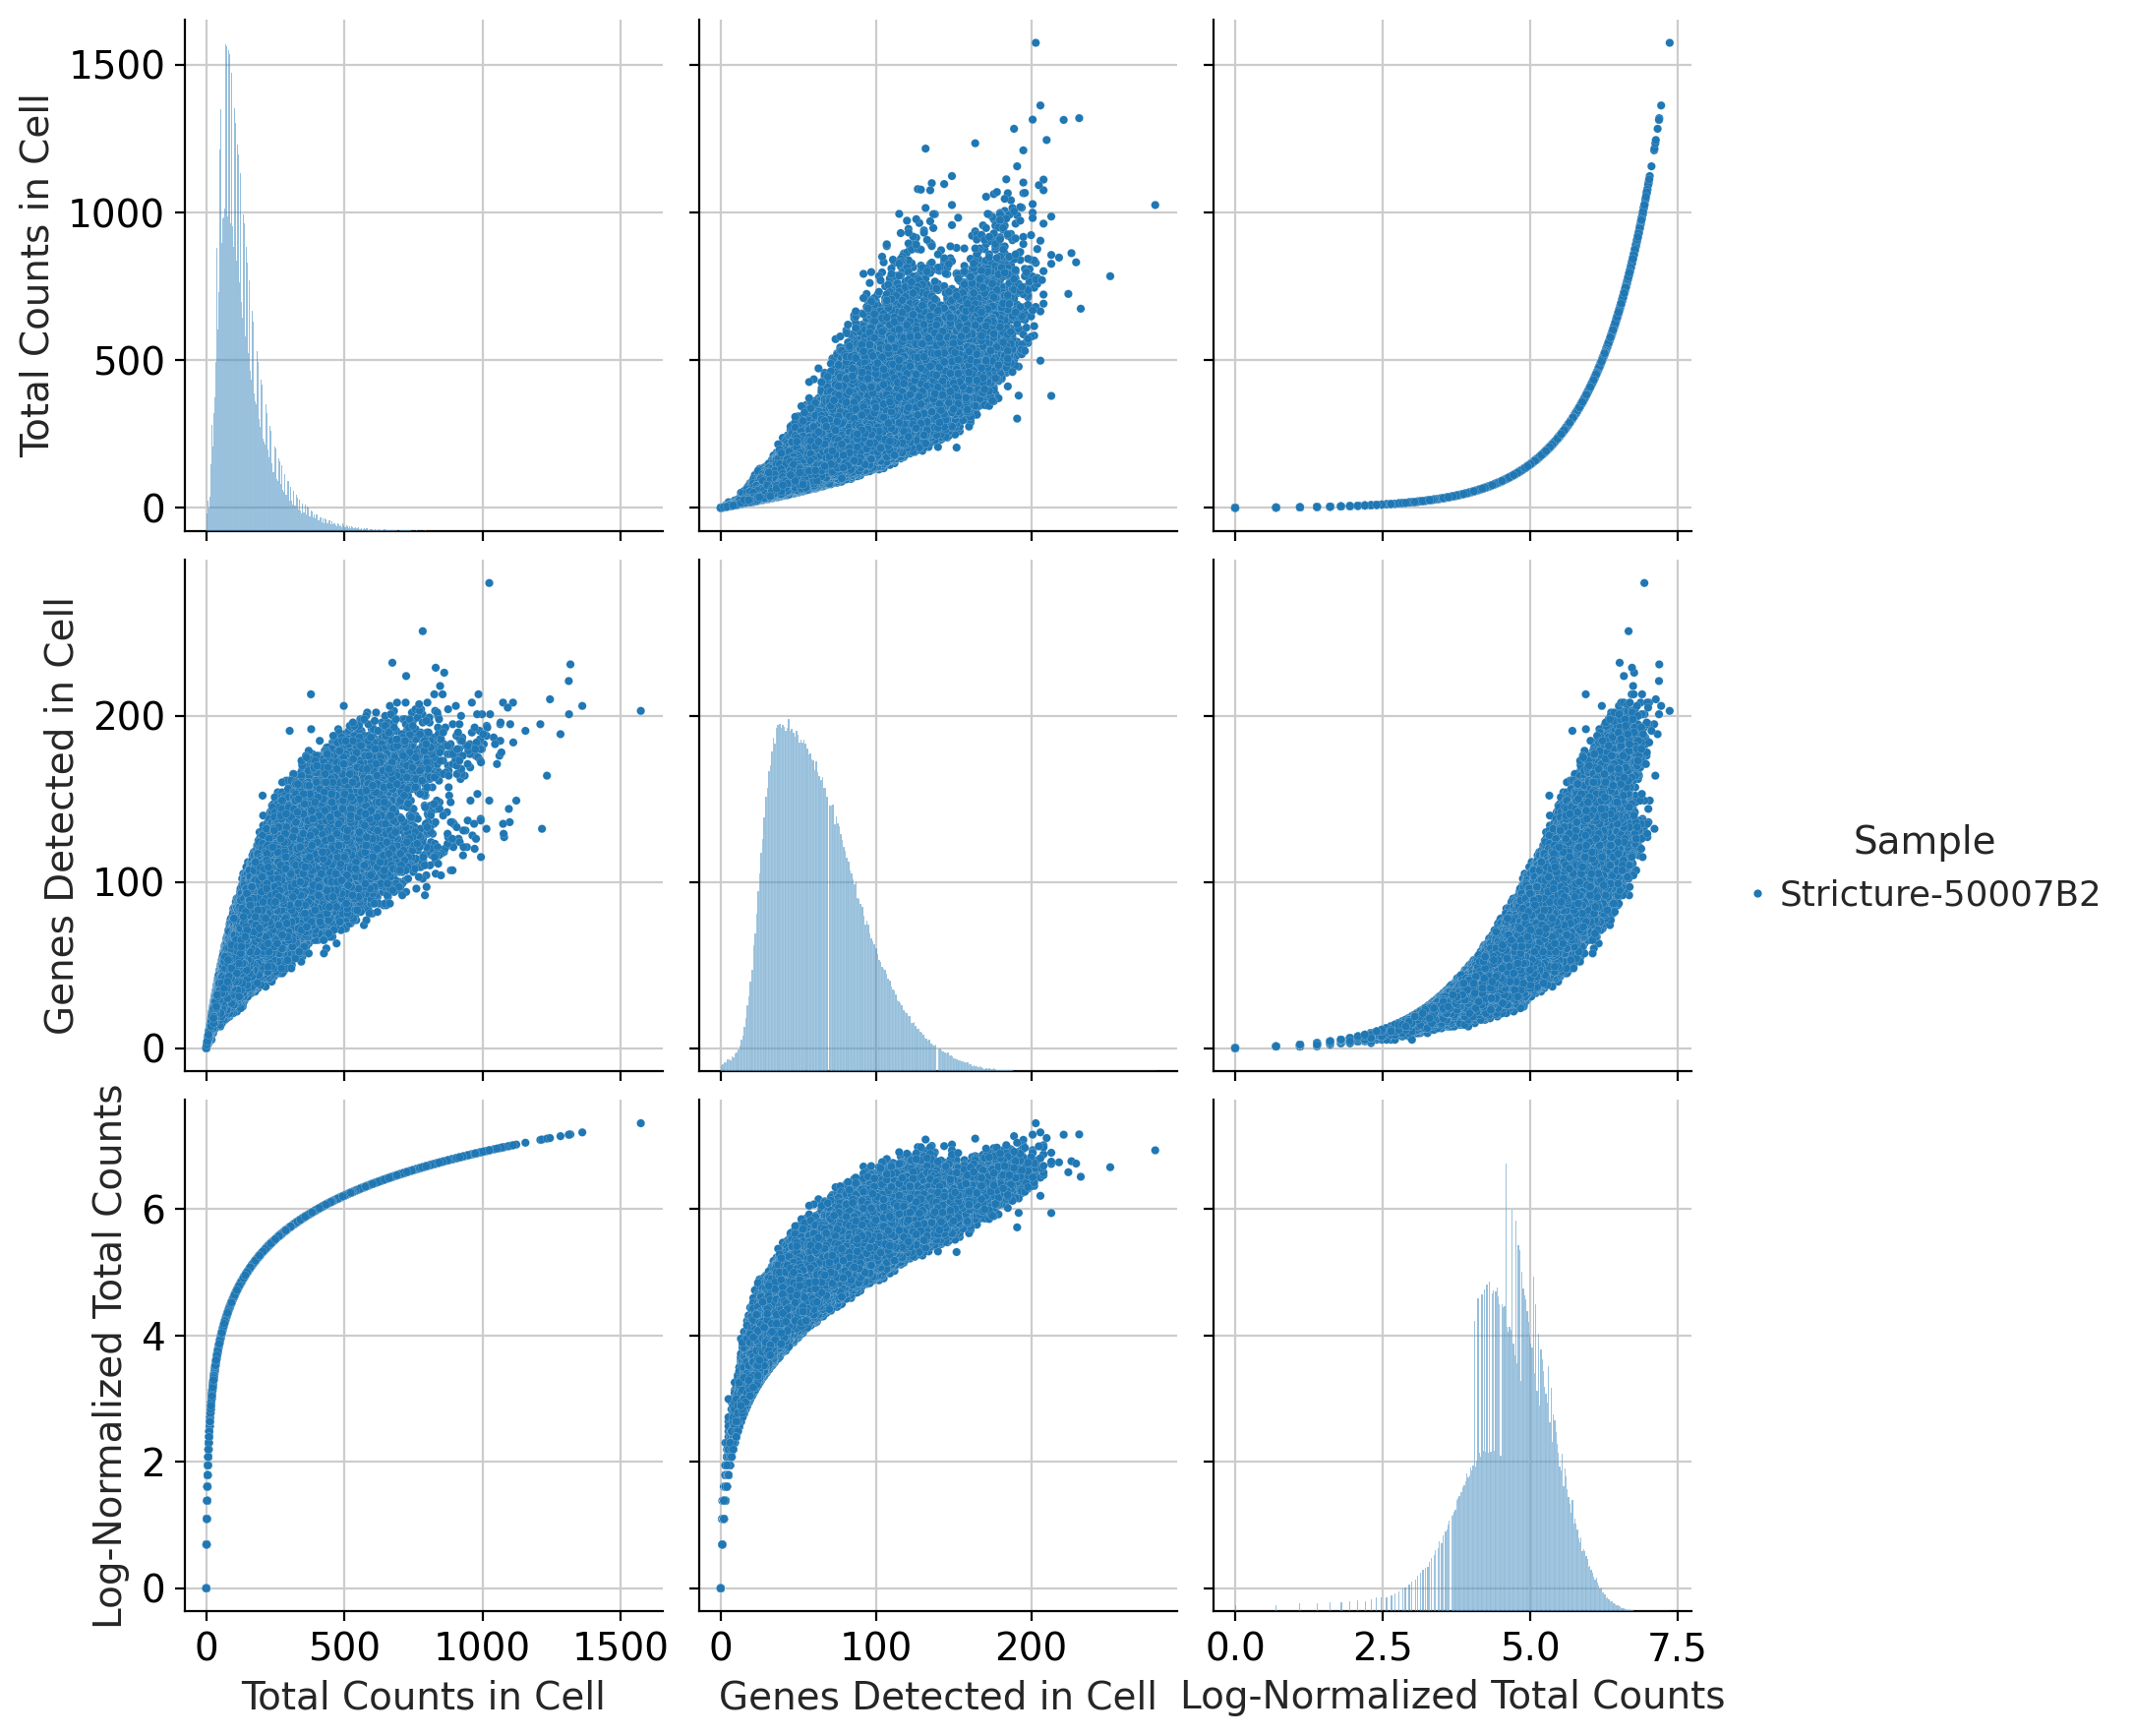

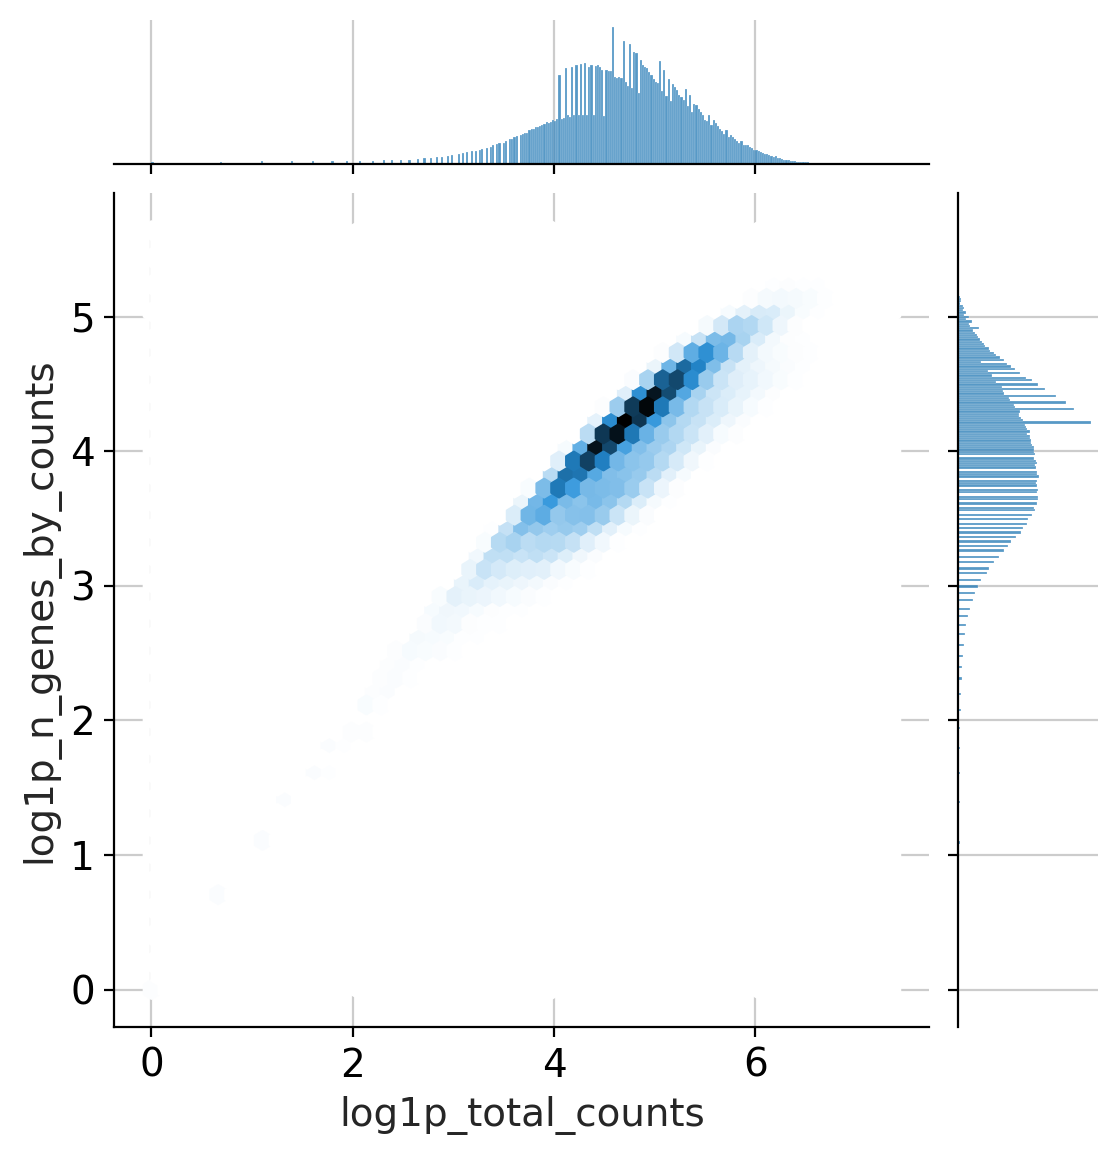

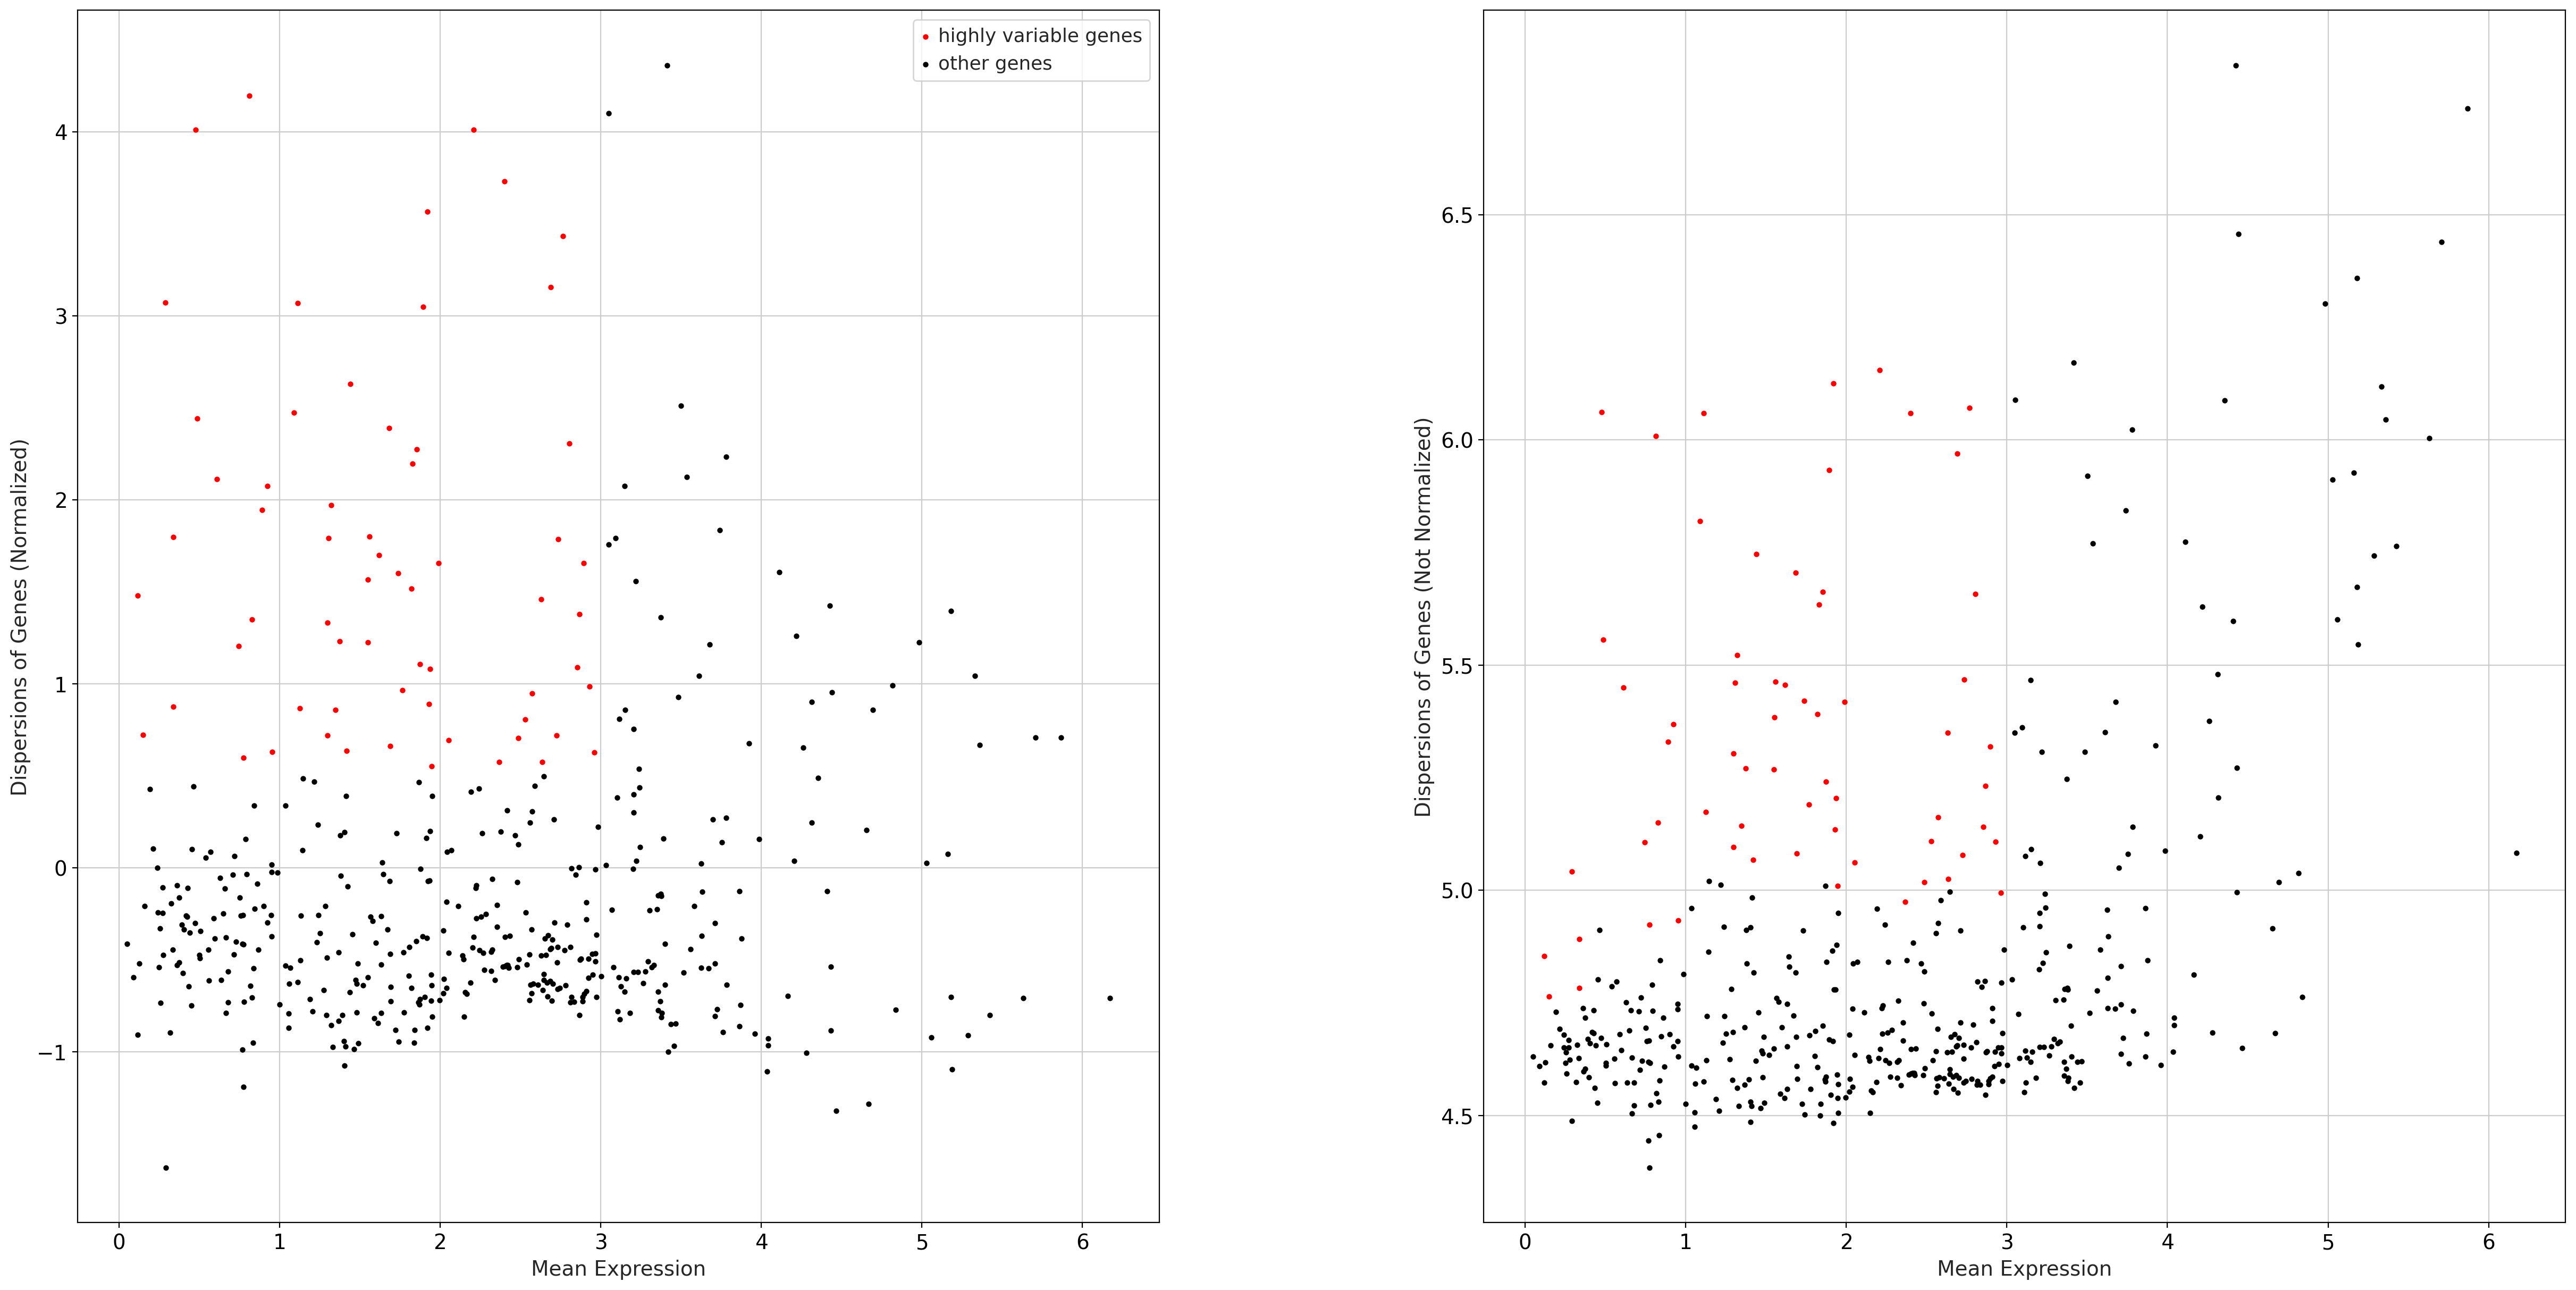


<<< NORMALIZING RAW GENE EXPRESSION >>>

	*** Scaling gene expression...

	*** Clipping maximum GEX SD to 10...

	*** Scaling => `.X` & scaled layer...
dsfasfda AnnData object with n_obs × n_vars = 505887 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Location', 'Stricture', 'Inflamed', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease_Status', 'Date Collected', 'Date Sectioned', 'Date Hybridization', 'Storage 4c', 'Created By', 'Created', 'Storage Status', 'Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Condition', 'file_path', 'out_file', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts'
    var: 'gene_ids', 'feature_types', 'genome', 

In [24]:
%%time

for i, s in enumerate(selves):
    f_o = str(selves[0].rna.obs.out_file.iloc[0])

    # Preprocessing
    print("\n\n", kws_pp, "\n\n")
    _ = s.preprocess(**kws_pp, figsize=(15, 15))  # preprocess

    # Clustering at Different Resolutions & Minimum Distances
    for x in kws_clustering:

        # Variables & Output Files
        print(kws_clustering[x])
        cct, cca, f_i = f"leiden_{x}", f"label_{x}", f"{s._library_id}_{x}"
        f_m = f"{f_o}_{x}_markers.csv" if out_dir else None

        # Clustering
        _ = s.cluster(**kws_clustering[x], key_added=cct, out_file=f_o)
        s.write_clusters(out_dir, col_cell_type=cct, overwrite=True)
        _ = s.plot_spatial(color=cct)
        _ = s.find_markers(col_cell_type=cct, kws_plot=False, out_file=f_m)
        _ = s.annotate_clusters(assign, col_cell_type=cct, col_annotation=cca)

    # Write Final Object
    s.write(f_o)